## Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train Greedy PDNN-PINN Method

In [8]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

Initial training...
0 0.2359339283377942 	Loss(validation) = 0.17148388321229
100 0.02750997800806727 	Loss(validation) = 0.09823576196986246
200 0.019333305925743817 	Loss(validation) = 0.09097146510060172
300 0.016511212129367465 	Loss(validation) = 0.0893357616911189
400 0.013821928484751417 	Loss(validation) = 0.08705301334617827
500 0.011834922422468728 	Loss(validation) = 0.08598467613988928
600 0.009534419372283151 	Loss(validation) = 0.08567848924520133
700 0.00770215778374495 	Loss(validation) = 0.08824542839372339
800 0.006226368761329775 	Loss(validation) = 0.09254606789645438
900 0.005007516668303671 	Loss(validation) = 0.09592911017287789
1000 0.0040973213876832676 	Loss(validation) = 0.09767240333727532
1100 0.0034361251608279594 	Loss(validation) = 0.09820025427049763
1200 0.0029195179262754855 	Loss(validation) = 0.09792246826999466
1300 0.0024909164122164902 	Loss(validation) = 0.09723566519325662
1400 0.002114422555841767 	Loss(validation) = 0.0963322041873574
1500 0.

Compute operators time: 0.00027489662170410156
Compute operators time: 0.0002720355987548828
Compute operators time: 0.00029206275939941406
Compute operators time: 0.0002391338348388672
Compute operators time: 0.0004169940948486328
Compute operators time: 0.0002849102020263672
Compute operators time: 0.0002770423889160156
Compute operators time: 0.0003120899200439453
Compute operators time: 0.0002799034118652344
Compute operators time: 0.00024199485778808594
Compute operators time: 0.00032210350036621094
Compute operators time: 0.0004131793975830078
Compute operators time: 0.0002601146697998047
Compute operators time: 0.0002551078796386719
Compute operators time: 0.0002429485321044922
Compute operators time: 0.00024175643920898438
Compute operators time: 0.00025010108947753906
Compute operators time: 0.0003108978271484375
Compute operators time: 0.0012722015380859375
Compute operators time: 0.0002837181091308594
Compute operators time: 0.00022983551025390625
Compute operators time: 0.0

Compute operators time: 0.00025916099548339844
Compute operators time: 0.0002288818359375
Compute operators time: 0.0002789497375488281
Compute operators time: 0.0002288818359375
Compute operators time: 0.00022029876708984375
Compute operators time: 0.00021910667419433594
Compute operators time: 0.00025916099548339844
Compute operators time: 0.0007140636444091797
Compute operators time: 0.000370025634765625
Compute operators time: 0.00027108192443847656
Compute operators time: 0.000270843505859375
Compute operators time: 0.0003249645233154297
Compute operators time: 0.00027298927307128906
Compute operators time: 0.0002942085266113281
Compute operators time: 0.00028014183044433594
Compute operators time: 0.0002598762512207031
Compute operators time: 0.00024819374084472656
Compute operators time: 0.0002601146697998047
Compute operators time: 0.00028395652770996094
Compute operators time: 0.0002961158752441406
Compute operators time: 0.00034809112548828125
Compute operators time: 0.000295

Compute operators time: 0.0003421306610107422
Compute operators time: 0.00027489662170410156
Compute operators time: 0.0002548694610595703
Compute operators time: 0.00026106834411621094
Compute operators time: 0.00023674964904785156
Compute operators time: 0.0002529621124267578
Compute operators time: 0.0003008842468261719
Compute operators time: 0.00037217140197753906
Compute operators time: 0.000331878662109375
Compute operators time: 0.0002548694610595703
Compute operators time: 0.00026702880859375
Compute operators time: 0.0002598762512207031
Compute operators time: 0.0002579689025878906
Compute operators time: 0.0002651214599609375
Compute operators time: 0.0002570152282714844
Compute operators time: 0.00026702880859375
Compute operators time: 0.0003447532653808594
Compute operators time: 0.0002849102020263672
Compute operators time: 0.0002810955047607422
Compute operators time: 0.0002491474151611328
Compute operators time: 0.000247955322265625
Compute operators time: 0.0002632141

Compute operators time: 0.0002658367156982422
Compute operators time: 0.00026798248291015625
Compute operators time: 0.0002751350402832031
Compute operators time: 0.0002491474151611328
Compute operators time: 0.00034928321838378906
Compute operators time: 0.0002532005310058594
Compute operators time: 0.00023603439331054688
Compute operators time: 0.0002789497375488281
Compute operators time: 0.00026226043701171875
Compute operators time: 0.00024509429931640625
Compute operators time: 0.0002281665802001953
Compute operators time: 0.0002880096435546875
Compute operators time: 0.000370025634765625
Compute operators time: 0.0002541542053222656
Compute operators time: 0.0002598762512207031
Compute operators time: 0.0002579689025878906
Compute operators time: 0.0002560615539550781
Compute operators time: 0.00023508071899414062
Compute operators time: 0.0002899169921875
Compute operators time: 0.0002770423889160156
Compute operators time: 0.000270843505859375
Compute operators time: 0.0002617

Compute operators time: 0.00023698806762695312
Compute operators time: 0.00024318695068359375
Compute operators time: 0.00027298927307128906
Compute operators time: 0.0003116130828857422
Compute operators time: 0.00024700164794921875
Compute operators time: 0.00025200843811035156
Compute operators time: 0.00022912025451660156
Compute operators time: 0.00028395652770996094
Compute operators time: 0.0002579689025878906
Compute operators time: 0.00025773048400878906
Compute operators time: 0.000240325927734375
Compute operators time: 0.00025010108947753906
Compute operators time: 0.0002639293670654297
Compute operators time: 0.0002472400665283203
Compute operators time: 0.000270843505859375
Compute operators time: 0.0002529621124267578
Compute operators time: 0.00023603439331054688
Compute operators time: 0.0002942085266113281
Compute operators time: 0.0002779960632324219
Compute operators time: 0.00026297569274902344
Compute operators time: 0.0002460479736328125
Compute operators time: 0

Compute operators time: 0.00023603439331054688
Compute operators time: 0.0002429485321044922
Compute operators time: 0.000286102294921875
Compute operators time: 0.00026798248291015625
Compute operators time: 0.00026226043701171875
Compute operators time: 0.00030112266540527344
Compute operators time: 0.00029087066650390625
Compute operators time: 0.0002512931823730469
Compute operators time: 0.00023031234741210938
Compute operators time: 0.0002410411834716797
Compute operators time: 0.00023794174194335938
Compute operators time: 0.0002372264862060547
Compute operators time: 0.0002651214599609375
Compute operators time: 0.0002739429473876953
Compute operators time: 0.0002682209014892578
Compute operators time: 0.00024509429931640625
Compute operators time: 0.00024199485778808594
Compute operators time: 0.00029015541076660156
Compute operators time: 0.00029087066650390625
Compute operators time: 0.00026798248291015625
Compute operators time: 0.00024080276489257812
Compute operators time

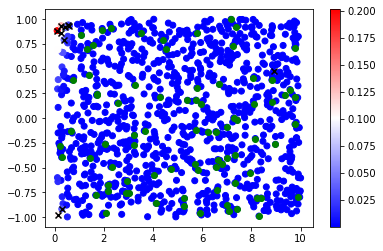

10000 0.14290121673335 	Loss(validation) = 0.07644683400223222
10100 0.11748967824555337 	Loss(validation) = 0.05854788071611476
10200 0.09798968026824824 	Loss(validation) = 0.04708270459591866
10300 0.0804965765829362 	Loss(validation) = 0.04538336635583518
10400 0.06522351141726224 	Loss(validation) = 0.04651752170020397
10500 0.0526999260987114 	Loss(validation) = 0.04736485443506378
10600 0.04273193940364673 	Loss(validation) = 0.04689311140688385
10700 0.03486590148299709 	Loss(validation) = 0.0446967792296972
10800 0.028668177054809455 	Loss(validation) = 0.04100033943677237
10900 0.023776011478142452 	Loss(validation) = 0.03645140954308083
11000 0.019883903316504806 	Loss(validation) = 0.03176190524275912
11100 0.016738504402813142 	Loss(validation) = 0.027504548775487685
11200 0.014141990944342774 	Loss(validation) = 0.02401104717249771
11300 0.011954045649813137 	Loss(validation) = 0.021395629661111998
11400 0.010086515477471813 	Loss(validation) = 0.019621133919768195
11500 

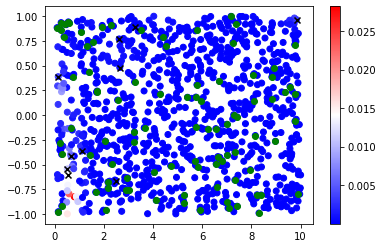

20000 0.0010320554590169883 	Loss(validation) = 0.0029519342508214997
20100 0.000567900704091328 	Loss(validation) = 0.0039323417232240265
20200 0.0003704970997923629 	Loss(validation) = 0.0050134428861677415
20300 0.0002792006117865828 	Loss(validation) = 0.005458228413137369
20400 0.00022317659066230545 	Loss(validation) = 0.00551974193358729
20500 0.0001831148418722617 	Loss(validation) = 0.005440721852677124
20600 0.0001529747137241907 	Loss(validation) = 0.005315757086693111
20700 0.00012979669484526393 	Loss(validation) = 0.005180465866925928
20800 0.00011169515819792165 	Loss(validation) = 0.005048169283441593
20900 9.735075220632051e-05 	Loss(validation) = 0.004923668247553735
21000 8.580154325571461e-05 	Loss(validation) = 0.004808276833744117
21100 7.634748782071073e-05 	Loss(validation) = 0.004701907585881504
21200 6.847976229898321e-05 	Loss(validation) = 0.004603979297543502
21300 6.18296256830366e-05 	Loss(validation) = 0.004513708109680987
21400 5.612966954148167e-05 	Lo

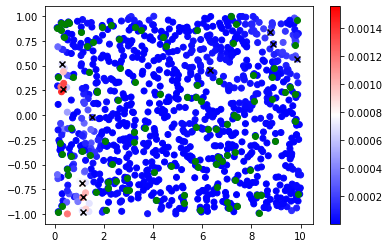

30000 0.00014161261188519697 	Loss(validation) = 0.00017835173632595934
30100 9.2589155387708e-05 	Loss(validation) = 0.0001690152219925967
30200 7.353080516821064e-05 	Loss(validation) = 0.0001544348595613997
30300 6.265706152401857e-05 	Loss(validation) = 0.00013894973290446078
30400 5.561049407082587e-05 	Loss(validation) = 0.00012510285970065434
30500 5.067990981099501e-05 	Loss(validation) = 0.00011334650605324217
30600 4.698799695033045e-05 	Loss(validation) = 0.00010353723077278118
30700 4.404758946375019e-05 	Loss(validation) = 9.543098554301742e-05
30800 4.1587152228349324e-05 	Loss(validation) = 8.876536830612545e-05
30900 3.945138209472504e-05 	Loss(validation) = 8.330434602742297e-05
31000 3.754938428223864e-05 	Loss(validation) = 7.885240136728271e-05
31100 3.5827103382525286e-05 	Loss(validation) = 7.520323629567991e-05
31200 3.424550311791561e-05 	Loss(validation) = 7.22477151253329e-05
31300 3.278122730976906e-05 	Loss(validation) = 6.982953415952125e-05
31400 3.1415802

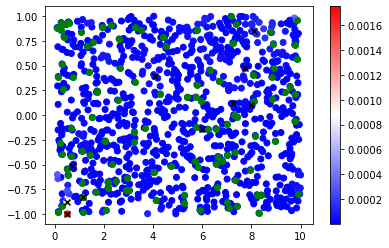

40000 9.944780453639395e-06 	Loss(validation) = 2.899242972151736e-05
40100 8.453238228090753e-06 	Loss(validation) = 2.8433892401232294e-05
40200 7.721478409663298e-06 	Loss(validation) = 2.7864467436950335e-05
40300 7.192929891535714e-06 	Loss(validation) = 2.7329782357670444e-05
40400 6.771871931437204e-06 	Loss(validation) = 2.686154893868952e-05
40500 6.421835018589687e-06 	Loss(validation) = 2.6444299021535973e-05
40600 6.123226654063551e-06 	Loss(validation) = 2.605858058984378e-05
40700 5.863401672304912e-06 	Loss(validation) = 2.5708779576979036e-05
40800 5.634309331778839e-06 	Loss(validation) = 2.5371519531992396e-05
40900 5.430167674597503e-06 	Loss(validation) = 2.504650964744537e-05
41000 5.2465577275260485e-06 	Loss(validation) = 2.4749781887289787e-05
41100 5.079816767987074e-06 	Loss(validation) = 2.4445757108349918e-05
41200 4.92747310508531e-06 	Loss(validation) = 2.4150242628457362e-05
41300 4.787760280251547e-06 	Loss(validation) = 2.3868668217713356e-05
41400 4.65

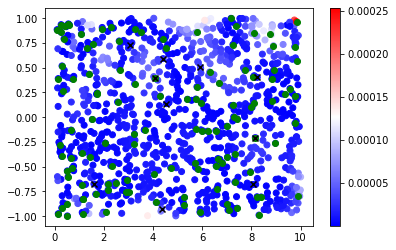

50000 1.9327275482612907e-06 	Loss(validation) = 1.9058540926083503e-05
50100 1.918169807676117e-06 	Loss(validation) = 1.9112438526316777e-05
50200 1.9047324814438969e-06 	Loss(validation) = 1.914704227033767e-05
50300 1.891574457740738e-06 	Loss(validation) = 1.9185065296576567e-05
50400 1.878691252659391e-06 	Loss(validation) = 1.9218414985275674e-05
50500 1.8660491788845992e-06 	Loss(validation) = 1.926039322686352e-05
50600 1.8535734210408505e-06 	Loss(validation) = 1.9315104265908455e-05
50700 1.8411606760935513e-06 	Loss(validation) = 1.9340274250598733e-05
50800 1.8292033622003988e-06 	Loss(validation) = 1.9402862089664834e-05
50900 1.8173729621308858e-06 	Loss(validation) = 1.9398184258038406e-05
51000 1.8057050571838938e-06 	Loss(validation) = 1.9428699635710576e-05
51100 1.7942320010515376e-06 	Loss(validation) = 1.945257441322913e-05
51200 1.7830206794339372e-06 	Loss(validation) = 1.947519508343471e-05
51300 1.7719785823884626e-06 	Loss(validation) = 1.9517602839255596e-05

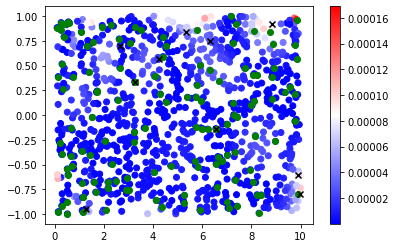

60000 1.2204668363898202e-06 	Loss(validation) = 2.1814797435021338e-05
60100 1.2105386776142222e-06 	Loss(validation) = 2.1825114593931436e-05
60200 1.203282131734347e-06 	Loss(validation) = 2.1851468717304805e-05
60300 1.1969842430237909e-06 	Loss(validation) = 2.18742102375097e-05
60400 1.1911563342523789e-06 	Loss(validation) = 2.1897431195370375e-05
60500 1.185686695653216e-06 	Loss(validation) = 2.1907435507781895e-05
60600 1.1804065047652035e-06 	Loss(validation) = 2.1925039588070937e-05
60700 1.1753078140681486e-06 	Loss(validation) = 2.193469714045463e-05
60800 1.1703411144653803e-06 	Loss(validation) = 2.1937397565630048e-05
60900 1.1654971171252693e-06 	Loss(validation) = 2.1972528628863264e-05
61000 1.1606659300995637e-06 	Loss(validation) = 2.1956373956203556e-05
61100 1.1559151518028778e-06 	Loss(validation) = 2.1959574574424234e-05
61200 1.1512456338114863e-06 	Loss(validation) = 2.1971597891480893e-05
61300 1.1466266498450426e-06 	Loss(validation) = 2.1988517169242104e-

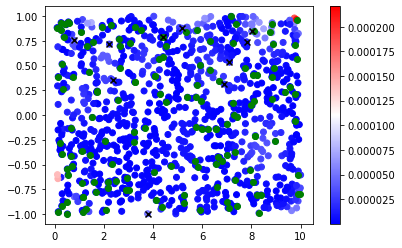

70000 1.3888244101239012e-06 	Loss(validation) = 2.2615037587185717e-05
70100 1.3521717678104044e-06 	Loss(validation) = 2.2955632955943158e-05
70200 1.330575085320827e-06 	Loss(validation) = 2.3193438988992276e-05
70300 1.3147864645833992e-06 	Loss(validation) = 2.3372097583569357e-05
70400 1.3020289591519491e-06 	Loss(validation) = 2.3503883885738237e-05
70500 1.2910384672984583e-06 	Loss(validation) = 2.360344505025311e-05
70600 1.2811715021940259e-06 	Loss(validation) = 2.367350782957884e-05
70700 1.2721135091979324e-06 	Loss(validation) = 2.372120242080397e-05
70800 1.26359335950734e-06 	Loss(validation) = 2.3745547479145247e-05
70900 1.2554796792883537e-06 	Loss(validation) = 2.3756212744090927e-05
71000 1.24781003079241e-06 	Loss(validation) = 2.3753321570037747e-05
71100 1.240339597507953e-06 	Loss(validation) = 2.3741355722622892e-05
71200 1.2330988248924882e-06 	Loss(validation) = 2.371938886527764e-05
71300 1.226041981008176e-06 	Loss(validation) = 2.369393339511063e-05
7140

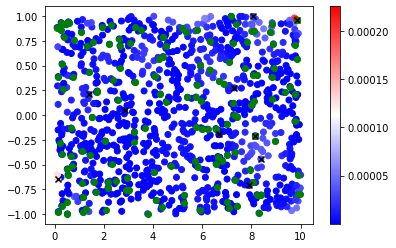

80000 0.00011835953869622058 	Loss(validation) = 2.654932797424323e-05
80100 0.00011244127319364998 	Loss(validation) = 2.9315375557944697e-05
80200 0.00010921633686604608 	Loss(validation) = 3.1293073648772695e-05
80300 0.00010682431245945087 	Loss(validation) = 3.2860820901044976e-05
80400 0.00010489336750290068 	Loss(validation) = 3.405759067194552e-05
80500 0.00010322864538771642 	Loss(validation) = 3.498252074921863e-05
80600 0.00010174122151937741 	Loss(validation) = 3.573799288172063e-05
80700 0.0001003926943628597 	Loss(validation) = 3.6308124125516796e-05
80800 9.915784807208149e-05 	Loss(validation) = 3.67066182648131e-05
80900 9.801453245920225e-05 	Loss(validation) = 3.699755528112854e-05
81000 9.69452499138427e-05 	Loss(validation) = 3.718174709420234e-05
81100 9.593440739936092e-05 	Loss(validation) = 3.729167696620956e-05
81200 9.496652581775078e-05 	Loss(validation) = 3.7324680248564465e-05
81300 9.40470595673399e-05 	Loss(validation) = 3.7306142719849575e-05
81400 9.31

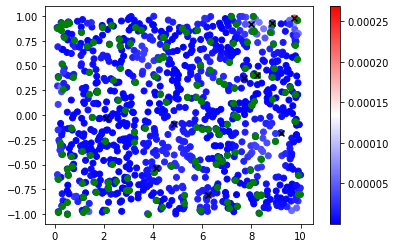

90000 5.21876621401928e-05 	Loss(validation) = 1.8614646143367464e-05
90100 5.197240056585672e-05 	Loss(validation) = 1.8536520153408976e-05
90200 5.1757248438582247e-05 	Loss(validation) = 1.8455936271916362e-05
90300 5.15476363861398e-05 	Loss(validation) = 1.837658389429282e-05
90400 5.1336869359745506e-05 	Loss(validation) = 1.8300305540869272e-05
90500 5.1127434089012654e-05 	Loss(validation) = 1.8225825633665384e-05
90600 5.0921170835671655e-05 	Loss(validation) = 1.8157087488826428e-05
90700 5.071684301256327e-05 	Loss(validation) = 1.8090068085324503e-05
90800 5.051650490683008e-05 	Loss(validation) = 1.8025099609069234e-05
90900 5.031548501856406e-05 	Loss(validation) = 1.7964444775802227e-05
91000 5.011814793399536e-05 	Loss(validation) = 1.7902691440008926e-05
91100 4.992209415209323e-05 	Loss(validation) = 1.7843344998860506e-05
91200 4.9730761007161265e-05 	Loss(validation) = 1.778028315883611e-05
91300 4.953903429480171e-05 	Loss(validation) = 1.772043947613237e-05
91400 

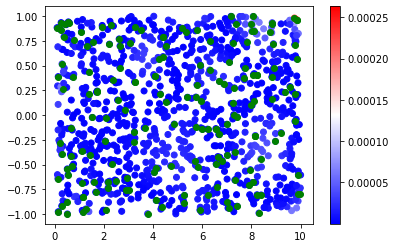

In [9]:
n = 1000 # number of parameters for which we compute residuals each iteration
num_new_params = 10 # number of parameters with which we augment data each iteration

# train PDNN
print("Initial training...")
pdnn_trainer.train()

new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=True
)


print("Beginning data augmentation cycles...")
for i in range(9):
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    #last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    #sample_indices = sample_indices[:last_index]
    sample_indices = sample_indices[:num_new_params]
    high_residual_params = new_parameters[sample_indices]
    plt.scatter(high_residual_params[:, 0].numpy().reshape(-1), 
                high_residual_params[:, 1].numpy().reshape(-1), marker='x', color='black')
    
    plt.show()
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=True
    )

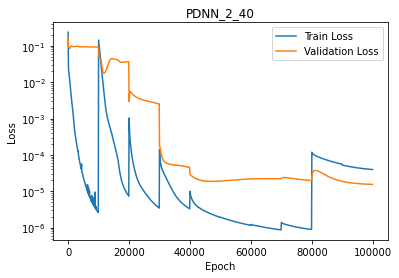

In [10]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.3 Train PRNN

In [11]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=213)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [12]:
prnn_trainer.train()

Compute operators time: 0.04744911193847656
Compute operators time: 0.0024509429931640625
0 2.1987226070679067 	Loss(validation) = 1.6084356365809882
100 0.10405533920184365 	Loss(validation) = 0.17015185521693552
200 0.07473525752260837 	Loss(validation) = 0.14565777991709433
300 0.05621453260909978 	Loss(validation) = 0.1322924116054915
400 0.04574771125576181 	Loss(validation) = 0.12774578134122516
500 0.03950047540405611 	Loss(validation) = 0.12436403946216884
600 0.035740786295930305 	Loss(validation) = 0.12207194466949606
700 0.03258400214930984 	Loss(validation) = 0.12046825673510321
800 0.029153581643903102 	Loss(validation) = 0.11834248020892864
900 0.025253328084011088 	Loss(validation) = 0.11467393397487585
1000 0.021295192469582128 	Loss(validation) = 0.10955862218067303
1100 0.01783679392761319 	Loss(validation) = 0.10462639758929382
1200 0.015048505718449501 	Loss(validation) = 0.10159479241034837
1300 0.012918222530734344 	Loss(validation) = 0.10106941778821277
1400 0.01

12200 3.874366508235154e-05 	Loss(validation) = 0.14099077620013023
12300 3.463015953942383e-05 	Loss(validation) = 0.1409845887517253
12400 3.402460533550885e-05 	Loss(validation) = 0.14085650688748416
12500 3.370327394273434e-05 	Loss(validation) = 0.14061218102016299
12600 0.0007409149947231545 	Loss(validation) = 0.14063227291630623
12700 3.242378037201885e-05 	Loss(validation) = 0.14038870137052883
12800 0.0001282999491841965 	Loss(validation) = 0.13964911398773056
12900 3.143955777266181e-05 	Loss(validation) = 0.1400724541480277
13000 0.0009780844263689826 	Loss(validation) = 0.14264757073302564
13100 3.0518353780158694e-05 	Loss(validation) = 0.13972699970379565
13200 3.1026243493925324e-05 	Loss(validation) = 0.1395519635970798
13300 3.2890578219511854e-05 	Loss(validation) = 0.139418654310134
13400 8.995890713932859e-05 	Loss(validation) = 0.13902249864678898
13500 2.8870997423315253e-05 	Loss(validation) = 0.13900776004616683
13600 3.423467869848539e-05 	Loss(validation) = 0

24300 1.6259887483423476e-05 	Loss(validation) = 0.12565403627128874
24400 1.1755913979933666e-05 	Loss(validation) = 0.12556264964515237
24500 4.650199022296067e-05 	Loss(validation) = 0.1254154407204682
24600 1.1640229614054802e-05 	Loss(validation) = 0.12538732342547
24700 1.2038769522958615e-05 	Loss(validation) = 0.12538131972450964
24800 1.1630701279918314e-05 	Loss(validation) = 0.12529373991517573
24900 1.1435962409235301e-05 	Loss(validation) = 0.1252516927718773
25000 0.0006324910795773847 	Loss(validation) = 0.1245539204522727
25100 1.1328225101144637e-05 	Loss(validation) = 0.12505319650259394
25200 1.1279209502125332e-05 	Loss(validation) = 0.1250172597819241
25300 1.1366079604967586e-05 	Loss(validation) = 0.1249496654263865
25400 1.1128772756310681e-05 	Loss(validation) = 0.12492717171804711
25500 6.981298374877291e-05 	Loss(validation) = 0.12504267108561642
25600 1.1018639022418887e-05 	Loss(validation) = 0.1247566227674077
25700 1.1141481267990152e-05 	Loss(validation)

36400 6.694984903858734e-06 	Loss(validation) = 0.12001428261382124
36500 6.620893456722453e-06 	Loss(validation) = 0.12004986167392545
36600 7.867042746876959e-06 	Loss(validation) = 0.11998663159601106
36700 6.570658045837681e-06 	Loss(validation) = 0.12002622838730326
36800 8.473690089812949e-06 	Loss(validation) = 0.1199499666143129
36900 6.904318748970364e-06 	Loss(validation) = 0.11988310183435912
37000 6.50277334917887e-06 	Loss(validation) = 0.11992436292257294
37100 0.0003717974086361415 	Loss(validation) = 0.12062711727375494
37200 6.4502649928407776e-06 	Loss(validation) = 0.11984724586591834
37300 0.00034679048768526785 	Loss(validation) = 0.11964500913874232
37400 6.401578654563286e-06 	Loss(validation) = 0.11981150879806361
37500 3.743529489047174e-05 	Loss(validation) = 0.1196393131989149
37600 2.864208964338374e-05 	Loss(validation) = 0.11995763910013105
37700 1.069102578394732e-05 	Loss(validation) = 0.11977522123069648
37800 7.956563515424767e-05 	Loss(validation) = 0

48500 4.5588440132501345e-06 	Loss(validation) = 0.1173906305907884
48600 4.518885907563916e-06 	Loss(validation) = 0.11741318473401713
48700 8.595501196293758e-06 	Loss(validation) = 0.11746042525009223
48800 1.5733614181938902e-05 	Loss(validation) = 0.11696881179333715
48900 1.681150538159737e-05 	Loss(validation) = 0.11739245955697133
49000 0.00012888667879872983 	Loss(validation) = 0.11725376495188433
49100 5.430716430345823e-06 	Loss(validation) = 0.11725573931082928
49200 5.016680294939899e-06 	Loss(validation) = 0.11737529113759232
49300 0.00018052417466557039 	Loss(validation) = 0.11770921918434261
49400 4.440750431473511e-06 	Loss(validation) = 0.11723741000181136
49500 2.8458793639191635e-05 	Loss(validation) = 0.11780158753878195
49600 4.411781622943873e-06 	Loss(validation) = 0.11726581571350876
49700 4.39481066468681e-06 	Loss(validation) = 0.11727123021881936
49800 8.880689809575439e-06 	Loss(validation) = 0.11717651355789765
49900 4.3758352964946315e-06 	Loss(validation

60600 2.4197238363235944e-05 	Loss(validation) = 0.11569968106820583
60700 5.044936748949091e-05 	Loss(validation) = 0.11592581289352287
60800 1.2850614355151535e-05 	Loss(validation) = 0.11655556145495598
60900 5.1697292484584075e-06 	Loss(validation) = 0.11619469351533514
61000 5.731745282192084e-06 	Loss(validation) = 0.11597551786104775
61100 3.736442644381986e-06 	Loss(validation) = 0.11615992003827502
61200 3.7766478417444206e-06 	Loss(validation) = 0.11644206027718475
61300 3.4181209934272694e-06 	Loss(validation) = 0.11616681900319147
61400 3.4631449577952795e-06 	Loss(validation) = 0.11611599452229081
61500 1.702183118004288e-05 	Loss(validation) = 0.11606446342090658
61600 3.982431769549166e-06 	Loss(validation) = 0.11610911876024224
61700 4.471113187497181e-06 	Loss(validation) = 0.11596210529374608
61800 3.3853078869199206e-06 	Loss(validation) = 0.11611759820921216
61900 3.6516487282956345e-06 	Loss(validation) = 0.1161041874602503
62000 6.032473805814079e-05 	Loss(validat

72600 2.3855250760124018e-05 	Loss(validation) = 0.11583196406881724
72700 5.677373935887454e-06 	Loss(validation) = 0.11593205444664324
72800 2.8591136198731553e-06 	Loss(validation) = 0.11559786298384947
72900 2.7993268387929043e-05 	Loss(validation) = 0.11556507940123009
73000 4.868106507624939e-06 	Loss(validation) = 0.11555040651863081
73100 3.387902901885636e-06 	Loss(validation) = 0.11567421778495375
73200 3.175465727730909e-06 	Loss(validation) = 0.11558277091230536
73300 6.1016115993985125e-06 	Loss(validation) = 0.11548400261993616
73400 3.535048258066046e-06 	Loss(validation) = 0.11555096576605932
73500 3.369757392548861e-06 	Loss(validation) = 0.11553668423535045
73600 7.936965474235922e-06 	Loss(validation) = 0.11554276086548416
73700 3.4602496856071084e-06 	Loss(validation) = 0.11554940730203869
73800 4.406941742111799e-06 	Loss(validation) = 0.11557766038783317
73900 3.120208599064771e-05 	Loss(validation) = 0.1156451376520027
74000 2.765332955280397e-06 	Loss(validation

84600 8.889482255076372e-06 	Loss(validation) = 0.11482069691125368
84700 2.3693282767329495e-06 	Loss(validation) = 0.11528235602065945
84800 2.565865201390117e-06 	Loss(validation) = 0.11525199574865255
84900 2.3627856611985547e-06 	Loss(validation) = 0.11529653121883215
85000 1.0101372404979549e-05 	Loss(validation) = 0.11506659406811487
85100 2.3585340098664245e-06 	Loss(validation) = 0.11526890047774961
85200 2.353715101895103e-06 	Loss(validation) = 0.11528268066618708
85300 2.41341134445352e-06 	Loss(validation) = 0.11528017245689323
85400 2.3480758725620747e-06 	Loss(validation) = 0.11529210143562564
85500 6.475108509964588e-06 	Loss(validation) = 0.1153008225651114
85600 2.3427950839070756e-06 	Loss(validation) = 0.11527685771630655
85700 4.353907680984427e-06 	Loss(validation) = 0.11532840713007195
85800 7.26667433670013e-05 	Loss(validation) = 0.11503773898126399
85900 2.3478028275680076e-06 	Loss(validation) = 0.11526284812012402
86000 2.5801272356999185e-06 	Loss(validatio

96700 2.1037317099233976e-06 	Loss(validation) = 0.11501336902270236
96800 2.0632488099257235e-06 	Loss(validation) = 0.1150439514143157
96900 3.4344741966227334e-06 	Loss(validation) = 0.1150647251742844
97000 2.991657319522601e-06 	Loss(validation) = 0.1150362766197566
97100 2.78059548116513e-06 	Loss(validation) = 0.11509397535884094
97200 2.2669122738195817e-06 	Loss(validation) = 0.11500247586413581
97300 2.0603922448355108e-06 	Loss(validation) = 0.11501888215122358
97400 2.3333933904419576e-06 	Loss(validation) = 0.11499220645568468
97500 3.498276710999762e-06 	Loss(validation) = 0.11505335751140756
97600 2.0847403337408894e-06 	Loss(validation) = 0.11504631098394873
97700 2.0478406523454257e-06 	Loss(validation) = 0.11502157181871135
97800 6.369445789168285e-06 	Loss(validation) = 0.11493321960119829
97900 8.344980994098607e-06 	Loss(validation) = 0.11524496508250738
98000 8.620167002742893e-06 	Loss(validation) = 0.11490527687685852
98100 2.4417845768869087e-06 	Loss(validatio

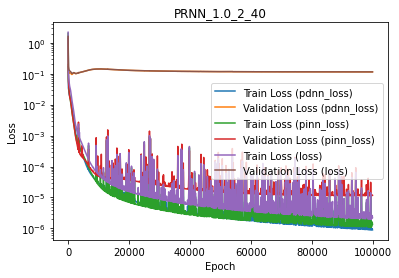

In [13]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

#### 4.5.4 Train PINN

In [14]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=213)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [15]:
pinn_trainer.train()

Compute operators time: 0.7477052211761475
Compute operators time: 0.002285003662109375
0 2.714984680847703 	Loss(validation) = 2.06050026213223
100 0.09690030449718572 	Loss(validation) = 0.0901206699987093
200 0.06685955100492047 	Loss(validation) = 0.05751049349721541
300 0.04690619871829086 	Loss(validation) = 0.037503189957886214
400 0.03843047844167848 	Loss(validation) = 0.029703675622256467
500 0.03347492412872204 	Loss(validation) = 0.024468419093974368
600 0.029551171183850988 	Loss(validation) = 0.020139070539505092
700 0.025915922140674657 	Loss(validation) = 0.01625805085756801
800 0.022268555007868025 	Loss(validation) = 0.012614581353141979
900 0.018860237302143514 	Loss(validation) = 0.0095013803587738
1000 0.01611797082410475 	Loss(validation) = 0.007256623718155887
1100 0.014081268053585465 	Loss(validation) = 0.005788392395711083
1200 0.012497590911621306 	Loss(validation) = 0.004802275319322444
1300 0.011188785240389583 	Loss(validation) = 0.004127347773545308
1400 

11800 0.00010101292961127485 	Loss(validation) = 0.00010980274716606417
11900 9.84125777140959e-05 	Loss(validation) = 0.00010626344581795179
12000 9.85610353820776e-05 	Loss(validation) = 0.00010675313293575461
12100 9.392102347410186e-05 	Loss(validation) = 9.988457349757129e-05
12200 9.129464120285356e-05 	Loss(validation) = 9.675373393601392e-05
12300 8.980316691611465e-05 	Loss(validation) = 9.564086048005213e-05
12400 8.701670143229886e-05 	Loss(validation) = 9.164984212227955e-05
12500 8.47817591294262e-05 	Loss(validation) = 8.894543297894099e-05
12600 8.257658313270252e-05 	Loss(validation) = 8.655244792494772e-05
12700 0.000122668738753302 	Loss(validation) = 0.00010076869379067676
12800 7.906027200311853e-05 	Loss(validation) = 8.302185153345333e-05
12900 7.714861714926981e-05 	Loss(validation) = 8.106010131324624e-05
13000 7.524433333705711e-05 	Loss(validation) = 7.931925346799703e-05
13100 0.0019463113437323968 	Loss(validation) = 0.002154768483155762
13200 7.193222935167

23500 2.3727735833415363e-05 	Loss(validation) = 7.073422567296101e-05
23600 2.35173694694029e-05 	Loss(validation) = 6.977774636851051e-05
23700 2.330942885111325e-05 	Loss(validation) = 6.915939766165547e-05
23800 3.928826706658992e-05 	Loss(validation) = 9.360432349161984e-05
23900 2.3107575503433738e-05 	Loss(validation) = 7.160978508988264e-05
24000 2.2893388591625823e-05 	Loss(validation) = 6.93470790534098e-05
24100 2.2706419371684056e-05 	Loss(validation) = 6.856790722874613e-05
24200 2.2516673746922025e-05 	Loss(validation) = 6.802872742779425e-05
24300 2.3531668227837364e-05 	Loss(validation) = 6.714643267454364e-05
24400 2.2402468509874983e-05 	Loss(validation) = 6.82042736328262e-05
24500 2.2050774922141925e-05 	Loss(validation) = 6.760379307511689e-05
24600 2.2068908777669257e-05 	Loss(validation) = 6.632864127889767e-05
24700 2.199154197940494e-05 	Loss(validation) = 6.732276032716885e-05
24800 2.1575171841146604e-05 	Loss(validation) = 6.683972909812671e-05
24900 2.13900

35100 1.0009886501946163e-05 	Loss(validation) = 4.019206405955976e-05
35200 2.5230242991185516e-05 	Loss(validation) = 9.222970617516366e-05
35300 9.878716944013384e-06 	Loss(validation) = 3.9925448970705884e-05
35400 9.785009702255438e-06 	Loss(validation) = 3.9478553014083186e-05
35500 0.0001885868222678131 	Loss(validation) = 8.848492986283994e-05
35600 9.66592296695733e-06 	Loss(validation) = 3.940595671398249e-05
35700 9.577151165363254e-06 	Loss(validation) = 3.889390970022501e-05
35800 9.489705596984552e-06 	Loss(validation) = 3.847759700054992e-05
35900 1.4711359265054658e-05 	Loss(validation) = 0.00011369648341307094
36000 9.404986420661536e-06 	Loss(validation) = 3.8854388173401894e-05
36100 9.318927059360025e-06 	Loss(validation) = 3.8199641244828095e-05
36200 9.237792161656482e-06 	Loss(validation) = 3.778842711259712e-05
36300 9.155500209883333e-06 	Loss(validation) = 3.7443286750996714e-05
36400 0.0002117879601930036 	Loss(validation) = 0.00025111995708736477
36500 9.086

46800 4.25554798776949e-06 	Loss(validation) = 2.380560010349139e-05
46900 0.00023905290266624043 	Loss(validation) = 0.0004045596753455188
47000 4.2243287242380255e-06 	Loss(validation) = 2.3713018917965764e-05
47100 4.171930069948648e-06 	Loss(validation) = 2.358622583507873e-05
47200 4.298372486422813e-06 	Loss(validation) = 2.343922859904571e-05
47300 4.237899626733386e-06 	Loss(validation) = 2.364522753260662e-05
47400 4.103249060692245e-06 	Loss(validation) = 2.3455163672944855e-05
47500 4.071695771254404e-06 	Loss(validation) = 2.3334851188442522e-05
47600 4.04036856474593e-06 	Loss(validation) = 2.3246887618440443e-05
47700 4.066214917851832e-06 	Loss(validation) = 2.3978228638598752e-05
47800 3.9934127992148365e-06 	Loss(validation) = 2.3229058825237213e-05
47900 2.2123971245431162e-05 	Loss(validation) = 4.416663124127074e-05
48000 3.9471518586101404e-06 	Loss(validation) = 2.3152704789025363e-05
48100 3.915698419476467e-06 	Loss(validation) = 2.2994216030474797e-05
48200 1.4

58400 5.843647152996634e-06 	Loss(validation) = 2.0612231006602768e-05
58500 5.75157825702019e-06 	Loss(validation) = 1.931345175095102e-05
58600 2.227172110025869e-06 	Loss(validation) = 1.8653087992336537e-05
58700 2.3884813285600096e-06 	Loss(validation) = 1.8504825867109408e-05
58800 2.1885400431357116e-06 	Loss(validation) = 1.8559645388750532e-05
58900 2.2809882596241978e-06 	Loss(validation) = 1.886204157123938e-05
59000 2.168363013277782e-06 	Loss(validation) = 1.8494486062043333e-05
59100 3.835020363122734e-06 	Loss(validation) = 2.2626429360965987e-05
59200 2.1510340395162553e-06 	Loss(validation) = 1.84235196454635e-05
59300 2.1384043447815524e-06 	Loss(validation) = 1.8350112297602795e-05
59400 2.3716041103889577e-06 	Loss(validation) = 1.8565850185545875e-05
59500 1.1110106163676793e-05 	Loss(validation) = 3.0100790324062724e-05
59600 1.2314905003476298e-05 	Loss(validation) = 4.887721480192458e-05
59700 2.1058735887373307e-06 	Loss(validation) = 1.8185394971946103e-05
598

70000 1.429166875118751e-06 	Loss(validation) = 1.5055395357136138e-05
70100 1.4452310841191657e-06 	Loss(validation) = 1.5112408250969657e-05
70200 7.481364585861911e-06 	Loss(validation) = 1.5924555256120093e-05
70300 2.836202854136228e-06 	Loss(validation) = 1.5473908589027565e-05
70400 5.890991636709996e-06 	Loss(validation) = 2.282574256654447e-05
70500 1.4192664990995391e-06 	Loss(validation) = 1.4940537559800199e-05
70600 1.2662102194875375e-05 	Loss(validation) = 4.459632831331781e-05
70700 1.398645645439523e-06 	Loss(validation) = 1.4858292002802272e-05
70800 1.3744364023809957e-05 	Loss(validation) = 2.5686015749848797e-05
70900 1.4717000654965294e-06 	Loss(validation) = 1.4780030200427402e-05
71000 1.3979766234055319e-06 	Loss(validation) = 1.4835763922139145e-05
71100 0.0001329471739139379 	Loss(validation) = 0.00012404701135433475
71200 1.378879515949154e-06 	Loss(validation) = 1.4739599715070072e-05
71300 1.2991978045823292e-05 	Loss(validation) = 2.7055111167212118e-05
7

81500 1.0533977391307204e-06 	Loss(validation) = 1.258779134683729e-05
81600 7.8075332570871e-05 	Loss(validation) = 6.016325689826889e-05
81700 1.0496566231745356e-06 	Loss(validation) = 1.2559923015456313e-05
81800 1.045720736104162e-06 	Loss(validation) = 1.251070949367578e-05
81900 1.7778366154318008e-05 	Loss(validation) = 2.5944377863876782e-05
82000 1.044419206369663e-06 	Loss(validation) = 1.2560136784639744e-05
82100 1.0404834280947197e-06 	Loss(validation) = 1.2490100412421161e-05
82200 1.0485609399992197e-06 	Loss(validation) = 1.2416732917233717e-05
82300 1.0419220792686927e-06 	Loss(validation) = 1.2542940416602343e-05
82400 1.0334754737764776e-06 	Loss(validation) = 1.2420138848892788e-05
82500 1.6107900448788704e-06 	Loss(validation) = 1.3644651007933101e-05
82600 1.0485652756011706e-06 	Loss(validation) = 1.2499888267652285e-05
82700 1.026981617187548e-06 	Loss(validation) = 1.2380354857603856e-05
82800 5.330687738486547e-05 	Loss(validation) = 6.098801297797462e-05
829

93100 1.7726188091760286e-06 	Loss(validation) = 1.122202976104743e-05
93200 1.6010210548228247e-06 	Loss(validation) = 1.2764251578851867e-05
93300 8.450085180635997e-07 	Loss(validation) = 1.0863248541616669e-05
93400 1.1258675543657274e-06 	Loss(validation) = 1.0849807176528263e-05
93500 8.761594615417555e-07 	Loss(validation) = 1.0826823219305257e-05
93600 1.2757974541896445e-06 	Loss(validation) = 3.158292079658488e-05
93700 1.9880544216360775e-06 	Loss(validation) = 1.2353612458598423e-05
93800 8.38940914659696e-07 	Loss(validation) = 1.081540082184374e-05
93900 1.2324594724384471e-06 	Loss(validation) = 1.0674585667639143e-05
94000 2.7161651916575597e-06 	Loss(validation) = 1.399418724836759e-05
94100 1.6691195415140148e-05 	Loss(validation) = 3.5542720185032005e-05
94200 8.348839845804654e-07 	Loss(validation) = 1.0780915771774215e-05
94300 1.61116566690343e-06 	Loss(validation) = 1.1132933832384207e-05
94400 1.254017125821152e-06 	Loss(validation) = 1.1098772395500357e-05
9450

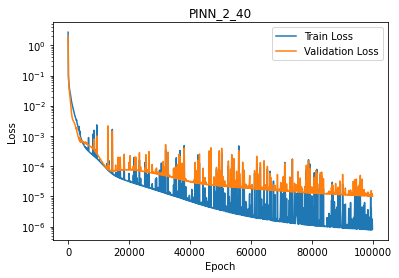

In [16]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

In [17]:
np.random.seed(42)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

#### 4.6.1 Greedy PDNN-PINN Error Analysis

In [18]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00010503323901425843	0.00010504030622353	4.098812211460208e-07
mean	0.006839169318392121	0.006839170198597292	6.090786453982541e-07
max	0.0969981455630035	0.09699815018890563	4.26441192323435e-06


#### 4.6.2 PRNN Error Analysis

In [19]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0017206687429776996	0.0017206753422481726	4.098812211460208e-07
mean	0.10130172355584488	0.10130172791778264	6.090786453982541e-07
max	0.9285590759064583	0.9285590755887982	4.26441192323435e-06


#### 4.6.3 PINN Error Analysis

In [20]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	3.894281503692503e-05	3.894242569503281e-05	4.098812211460208e-07
mean	0.005732294581299544	0.005732294607295494	6.090786453982541e-07
max	0.21638209888186732	0.2163821021350552	4.26441192323435e-06
